<a href="https://colab.research.google.com/github/MarvinKweyu/ode_models/blob/main/Ross_Models_with_initial_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Todo

1. Check basic and extended *Ross*-model for the spread of malaria.

## REMARK BM

1. Girolami uses Gamma priors in Section 7 of Bayesian Inference for Differential Equations.

**Motivation**: This is a reasonable prior density to assume for these parameters as, (1) it has support on the positive part of the real line and so satisfies the positivity constraints on the kinetic parameters and the noise variance, (2) it possesses a variance which is sufficiently wide to cover the plausible range of values for the kinetic parameters so as to retain the same scaling as the variables S, D, R and Rpp of the model.


2. SA COVID-19 study uses mostly lognormal for the parameters and half-Cauchy for the initial state based on Priesemann group paper/github  

In [2]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
!pip install pints

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.9/284.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 8.5 MB/s eta 0:00:00


In [3]:
import pints
import pints.toy
import pints.plot

In [4]:
a_prior = pints.GammaLogPrior(a=1, b=1) #? review
b_prior = pints.HalfCauchyLogPrior(location=0, scale=1) # to give +ve vals. No -ve humans
c_prior = pints.UniformLogPrior(0, 1) #

<ipython-input-4-54615cba562a>:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  c_prior = pints.UniformLogPrior(0, 1)


In [5]:
samples = c_prior.sample(n=1_000)

In [6]:
np.min(samples)==0.0

False

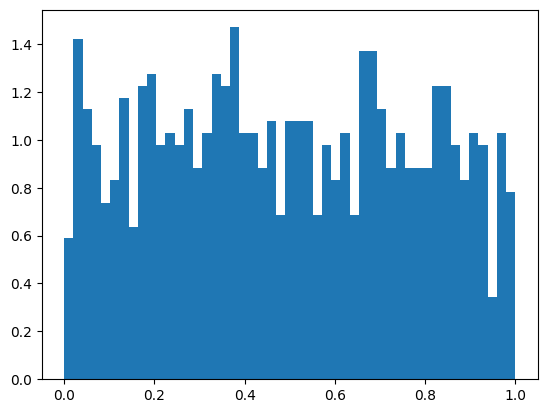

In [7]:
plt.hist(x=samples, density=True, bins=np.linspace(0, 1, 50));

# Basic model $\text{Ross}_0$

In [8]:
class ModelRoss0(pints.ForwardModel, pints.toy.ToyModel):
    """
    my_model = ModelRoss0(t0=1, tf=34, model_pars=6)
    """
    def __init__(self, s0, t0, tf, nbsteps, model_pars: int = 6):
        if len(s0) != 2:
            raise ValueError('Initial state must have 2 coordinates.')
        if np.any(s0 < 0):
            raise ValueError('State variables cannot be negative.')
        self.s0 = s0
        self.t_span = np.linspace(t0, tf, num=nbsteps, endpoint=True)
        self.pars = model_pars
        self.unknowns = None

    def Ross0(self, s, t, a, b, c, m, mu, r):
        '''INPUT: state $s = (h, m)$, imestep '$t$, and
                  the reduced number of parameters A, B, C, D of the dynamical system
           OUTPUT: change in state $ds/dt = (dh/dt, dm/dt)$.
           REMARK: solve_ivp assumes signature time, state, parameters
                   while ode_int signature state, time, parameters,
                   i.e. time and state are reversed.
        '''
        (Ih, Im) = s
        A, B = a*b*m, a*c
        dIh = -r*Ih + A*Im*(1-Ih)
        dIm = -mu*Im + B*Ih*(1-Im)
        return np.array([dIh, dIm])

    def simulate(self, parameters, times):
        a, b, c, m, mu, r = parameters
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        y = odeint(self.Ross0, self.s0, times, args=(a, b, c, m, mu, r))
        return y

    def n_parameters(self):
        # Parameters are the unknowns. Here, the model parameters a, b, c, m, mu, and r, and
        # the variances of the noise in the observations of h and m.
        # Return the numnber of 'parameters'
        return 6

    def n_outputs(self):
        """ See :meth:`pints.ForwardModel.n_outputs()`. """
        # essentially ih and Im
        return 2

### Basic reproductive number

The basic reproductive number is defined as
$$R_0 = \frac{ma^2bc}{r \mu}$$

In [9]:
def get_parameter_values(pars):
    return pars[r'$a$'], pars[r'$b$'], pars[r'$c$'], pars[r'$m$'], pars[r'$\mu_m$'], pars[r'$r$']

In [10]:
def get_basic_reproductive_number(pars):
    # check on this num
    a, b, c, m, mu, r = get_parameter_values(pars)
    return (m*(a**2)*b*c)/(r*mu)

## Model $Ross_0$ and its Parameter Values

Parameter values used in Figure 3 of Mandal et al. Malaria Journal 2011, 10:202 are given below.

def Ross0(t, s, A, B, C, D):
    '''INPUT: timestep '$t$, state $s$, and parameters of the dynamical system
       OUTPUT: change in state $ds/dt$.
       REMARK: solve_ivp assumes signature time, state, parameters
               while ode_int signature state, time, parameters,
               i.e. time and state are reversed.'''
    (h, m) = s
    dhdt = -A*h + B*m*(1-h)
    dmdt = -C*m + D*h*(1-m)
    return np.array([dhdt, dmdt])

In [11]:
PARS_ROSS0_Fig3 = {r'$a$':0.2, r'$b$':0.5, r'$c$':0.5, r'$m$':20, r'$\mu_m$':0.12, r'$r$':0.01}

In [12]:
get_parameter_values(PARS_ROSS0_Fig3)

(0.2, 0.5, 0.5, 20, 0.12, 0.01)

In [13]:
get_basic_reproductive_number(PARS_ROSS0_Fig3)

166.6666666666667

In [14]:
# after creating an instance of the model
def run_simulation(model):
    times = model.t_span
    pars = model.pars
    return model.simulate(pars, times)
  #

In [38]:
def plot_Ross0_simulation(times, states):
    """
    Plot humans and mosquitos
    """
    (h, m) = states[:,0], states[:,1]
    plt.plot(times, h, color='brown', label=r'$h$')
    plt.plot(times, m, color='red', label=r'$m$')
    return plt

In [16]:
def plot_Ross1_simulation(times, states):
    """
    Ignore any Ross1
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
    (Sh, Ih, Rh, Sm, Im) = states[:,0], states[:,1], states[:,2], states[:,3], states[:,4]
    ax.plot(times, Sh, color='blue', label=r'$S_h$')
    ax.plot(times, Ih, color='red', label=r'$I_h$')
    ax.plot(times, Rh, color='green', label=r'$R_h$')
    ax.plot(times, Sm, '--', color='blue', label=r'$S_m$')
    ax.plot(times, Im, '--', color='red', label=r'$I_m$')
    ax.legend()
    return fig

In [17]:
from types import NoneType #? where is NoneType being used after import
# Todo: specify return type as tuple
def run_and_plot_simulation(model, basic_Ross_p=True) -> tuple:
    states = run_simulation(model)
    times = model.t_span
    fig = plot_Ross0_simulation(times, states) if basic_Ross_p else plot_Ross1_simulation(times, states)
    return fig, states

In [18]:
type(plt)

module

# Unknowns in $Ross_0$

Everything we are uncertain about are called the unknowns. We want to generate a posterior distribution over these unknowns.

In our case the unknowns are the model parameters $a, b, c, m, \mu_m, \text{ and } r$, and the variances $\sigma_h$ and $\sigma_m$ of the noise in ourobservations of $h$ and $m$.

In order to obtain the posterior we have to define a prior for each of the unknowns. We assume a uniform prior for the model parameters and
a Gaussian one for the noise.

In [19]:
par_strings = [r'$a$', r'$b$', r'$c$', r'$m$', r'$\mu_m$', r'$r$']

In [20]:
PARS_Fig3 = {r'$a$':0.2, r'$b$':0.5, r'$c$':0.5, r'$m$':20, r'$\mu_m$':0.12, r'$r$':0.01}
# infections in humans vs infections in mosquitos
# ToDo: move these to constants?  since they are proved.
S0_Fig3 = np.array([0.01, 0.001])

# get_parameter_values(PARS_Fig3) = (0.2, 0.5, 0.5, 20, 0.12, 0.01)
GROUND_TRUTH_Fig3 = np.append(np.array(get_parameter_values(PARS_Fig3)), S0_Fig3)
GROUND_TRUTH_Fig3

array([2.0e-01, 5.0e-01, 5.0e-01, 2.0e+01, 1.2e-01, 1.0e-02, 1.0e-02,
       1.0e-03])

In [21]:
def create_samples(truth, N: int = 1):
    """
    truth: ? ground truths: a np array )
    n: int :num of samples
    """
    samples = np.zeros(shape=(N, truth.size))
    noises = 1 + 0.1*np.random.randn(N) # likelihood. Random noise
    for idx in np.arange(N):
        samples[idx,:] = noises[idx]*truth # place it
    return samples

In [22]:
def Ross0(s, t, a, b, c, m, mu, r):
    '''INPUT: state $s = (h, m)$, imestep '$t$, and
              the reduced number of parameters A, B, C, D of the dynamical system
       OUTPUT: change in state $ds/dt = (dh/dt, dm/dt)$.
       REMARK: solve_ivp assumes signature time, state, parameters
               while ode_int signature state, time, parameters,
               i.e. time and state are reversed.
    '''
    (Ih, Im) = s
    A, B = a*b*m, a*c
    dIh = -r*Ih + A*Im*(1-Ih)
    dIm = -mu*Im + B*Ih*(1-Im)
    return np.array([dIh, dIm])

In [23]:
Y0 = GROUND_TRUTH_Fig3[6:]
ARGS = GROUND_TRUTH_Fig3[:6]
Y0, ARGS

(array([0.01 , 0.001]),
 array([2.0e-01, 5.0e-01, 5.0e-01, 2.0e+01, 1.2e-01, 1.0e-02]))

In [24]:
Y0.shape

(2,)

In [25]:
tuple(ARGS)

(0.2, 0.5, 0.5, 20.0, 0.12, 0.01)

In [26]:
y = odeint(Ross0, y0=Y0, t=np.arange(150), args=tuple(ARGS))
# can use pymc or odeint

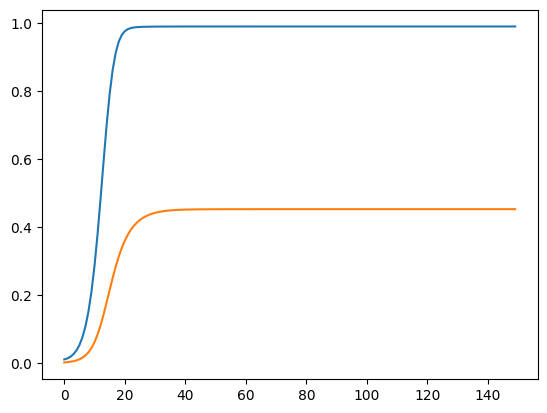

In [27]:
plt.plot(y) # initial plot without uncertainity

In [39]:
SAMPLES = create_samples(truth=GROUND_TRUTH_Fig3, N=1_000)
type(SAMPLES)

numpy.ndarray

In [40]:
SAMPLES
# [A, B, C, R, MU, M] * 1000

array([[0.1958829 , 0.48970725, 0.48970725, ..., 0.00979414, 0.00979414,
        0.00097941],
       [0.18575225, 0.46438064, 0.46438064, ..., 0.00928761, 0.00928761,
        0.00092876],
       [0.22332171, 0.55830428, 0.55830428, ..., 0.01116609, 0.01116609,
        0.00111661],
       ...,
       [0.19615338, 0.49038345, 0.49038345, ..., 0.00980767, 0.00980767,
        0.00098077],
       [0.19142167, 0.47855418, 0.47855418, ..., 0.00957108, 0.00957108,
        0.00095711],
       [0.19574248, 0.48935621, 0.48935621, ..., 0.00978712, 0.00978712,
        0.00097871]])

In [29]:
# OBS

In [30]:
def multiple_runs(samples: np.ndarray = [], t_final: int =150):

    N, _ = samples.shape # ? prolly 1000
    Ih = np.zeros(shape=(N, t_final))
    Im = np.zeros_like(Ih)

    for n in np.arange(N):
        sample = samples[n]
        initial_state, pars = sample[6:], tuple(sample[:6]) # come back here
        y = odeint(Ross0, y0=initial_state, t=np.arange(t_final), args=pars)
        yT = y.T # where t = time. Confirm
        Ih[n,:], Im[n,:] = yT[0], yT[1]
    return Ih, Im


In [31]:
Ih, Im = multiple_runs(samples=SAMPLES)

In [32]:
def plot_uncertainty(Ih, Im, t_final):
    avg_Ih, std_Ih = np.average(Ih, axis=0), np.std(Ih, axis=0)
    avg_Im, std_Im = np.average(Im, axis=0), np.std(Im, axis=0)
    avg_Ih, std_Ih = avg_Ih[:t_final], std_Ih[:t_final]
    avg_Im, std_Im = avg_Im[:t_final], std_Im[:t_final]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    dom = np.arange(t_final)

    ax.plot(dom, avg_Ih, color='blue', label=r'$I_h$')
    plt.fill_between(dom, avg_Ih - std_Ih, avg_Ih + std_Ih,
                     color='blue', alpha=0.2)
    ax.plot(dom, avg_Im, color='red', label=r'$I_m$')
    ax.fill_between(dom, avg_Im - std_Im, avg_Im + std_Im,
                    color='red', alpha=0.2)
    ax.set(xlabel='Time (days)', ylabel='Prevalence')
    ax.legend()
    return fig

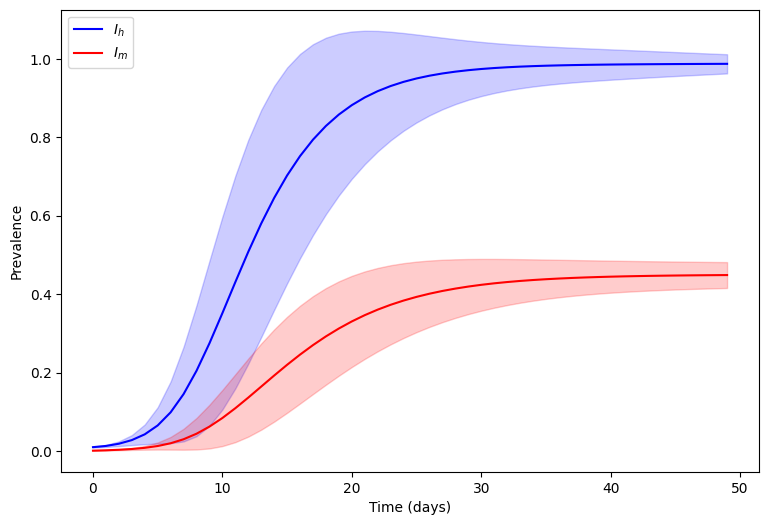

In [33]:
FIG2 = plot_uncertainty(Ih, Im, t_final=50)

In [34]:
plt.scatter

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)>

In [35]:
FIG2.savefig('./UncertaintyProp')

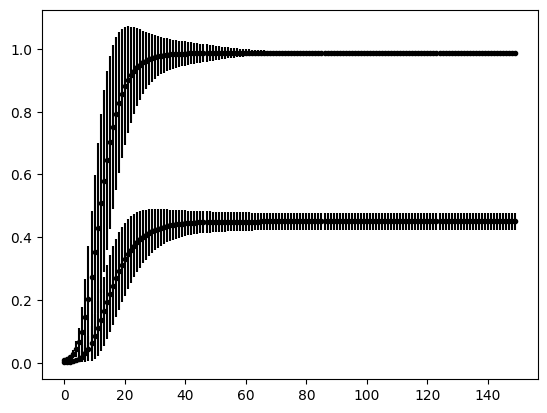

In [36]:
plt.errorbar(x=np.arange(150), y=np.average(Ih, axis=0), yerr=np.std(Ih, axis=0), fmt='.k');
plt.errorbar(x=np.arange(150), y=np.average(Im, axis=0), yerr=np.std(Im, axis=0), fmt='.k');

In [37]:
plt.errorbar(x=np.arange(150), y=np.arange(150), yerr=None, xerr=None, fmt='', ecolor=None, elinewidth=None, capsize=None, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, *, data=None)

SyntaxError: iterable argument unpacking follows keyword argument unpacking (<ipython-input-37-036ee837af3d>, line 1)

In [ ]:
np.std

In [ ]:
S = SAMPLES[0]
initial_state, pars = S[6:], tuple(S[:6])
initial_state, pars

In [ ]:
y = odeint(Ross0, y0=initial_state, t=np.arange(150), args=tuple(pars))

In [ ]:
INIT_SAMPLES = np.vstack((GROUND_TRUTH_Fig3*0.9,
                          GROUND_TRUTH_Fig3*0.95,
                          GROUND_TRUTH_Fig3*1.05))
INIT_SAMPLES

In [ ]:
M0 = ModelRoss0(s0=S0_Fig3,
                t0=0, tf=250, nbsteps=25,
                model_pars=get_parameter_values(PARS_Fig3))

In [ ]:
fig_test, STATES = run_and_plot_simulation(model=M0)

In [ ]:
print(STATES)

In [ ]:
fig_test.savefig("chores.png")

In [ ]:
OBS = np.random.uniform(low=0.9, high=1.1, size=STATES.shape)*STATES
#! states is a nontype object

In [ ]:
plt.scatter(OBS[:,0], OBS[:,1], color='red')
plt.plot(STATES, color='blue');

In [ ]:
M0Problem = pints.MultiOutputProblem(M0, np.arange(0, 250, 10), OBS)

## Priors

**REMARK BM**: Neglect priors, likelihoods, and posteriors for the moment. We will use

1. lognormal priors for the parameters of $Ross_0$ since they are all positive. We still have to determine the parameters of the lognormal.
2. half-Cauchy for the initial state. Again we still have to determine the parameters of these distributions.

In [ ]:
pars_log_prior = pints.UniformLogPrior(
    # Sequence of parameters: [r'$a$', r'$b$', r'$c$', r'$m$', r'$\mu_m$', r'$r$']
    # Each row contain the lower and upper bound of the corresponding parameter
    #lower_or_boundaries=
    [0.01, 0.2, 0.4, 0.5, 0.05, 0.005],
    #upper=
    [0.5,  0.5, 0.5,  40, 0.5,  0.5])

In [ ]:
state_log_prior = pints.UniformLogPrior(
    # Prevalence of Ih followed by that of Im
    lower_or_boundaries=[0.0001, 0.0001],
    upper=[1, 1])


In [ ]:
M0LogPrior = pints.ComposedLogPrior(pars_log_prior)
M0LogLikelihood = pints.GaussianKnownSigmaLogLikelihood(M0Problem, sigma=0.01)
M0LogPosterior = pints.LogPosterior(M0LogLikelihood, M0LogPrior)
M0Error = pints.SumOfSquaresError(M0Problem)

In [ ]:
pints.mcmc_sample(log_pdf=M0LogPosterior, chains=1, x0=[GROUND_TRUTH_Fig3])

In [ ]:
MCMC = pints.MCMCController(M0LogPosterior, 3, INIT_SAMPLES, method=pints.HaarioBardenetACMC)

In [ ]:
def setup_prior():
    pass

In [ ]:
def generate_initial_samples(model, n_chains=4):
    pars, init_state = model.pars, model.s0
    parent_sample = np.append(pars, init_state)
    n_unknowns = len(pars) + len(init_state)
    scales = np.random.uniform(low=0.9, high=1.1, size=(n_chains, n_unknowns))
    offspring_samples = scales*parent_sample
    return offspring_samples

In [ ]:
pe

In [ ]:
def run_sampler(model, s=0.01, n_chains=4, max_iter=3_000):
    times = model.t_span
    states = run_simulation(model)
    N, d = states.shape
    obs = states + s*np.random.randn(N, d)
    problem = pints.MultiOutputProblem(model, times, obs)
    error = pints.SumOfSquaresError(problem)
    log_likelihood = pints.GaussianLogLikelihood(problem)
    initial_samples = generate_initial_samples(model, n_chains)

    mcmc = pints.MCMCController(log_likelihood, n_chains, initial_samples, method=pints.HaarioBardenetACMC)
    mcmc.set_max_iterations(max_iter)
    mcmc.set_log_to_screen(False)
    chains = mcmc.run()
    return mcmc, chains, problem

## Run MCMC to obtain the posterior

In [ ]:
MCMC_R0, CHAINS_R0, PROBLEM_0 = run_sampler(model=M0)

In [ ]:
print(CHAINS_R0)

In [ ]:
print(CHAIN)

In [ ]:
MCMC_R0.time()

In [ ]:
# SAMPLES0 = CHAINS0[0, -1000:]
SAMPLES0 = CHAINS_R0[0, -1000:]

plt.figure()
fig, axes = pints.plot.series(SAMPLES0, M0Problem)
axes[0].plot(TIMES0, OBS0[:, 0], c='red', alpha=0.1)
axes[1].plot(TIMES0, OBS0[:, 1], c='blue', alpha=0.1);

In [ ]:
# Check convergence and other properties of chains
RESULTS_R0 = pints.MCMCSummary(
    chains=CHAINS_R0,
    time=MCMC_R0.time(),
    parameter_names=[r'$a$', r'$b$', r'$c$', r'$m$', r'$\mu_m$', r'$r$',
                     r'$\sigma_h$', r'$\sigma_m$'])
print(RESULTS_R0)

plt.figure()
pints.plot.trace(CHAINS_R0)
plt.show()

## Intervention

Mosquito nets are distributed reducing the parameter from $a=0.2$ to $a=0.01$.

In [ ]:
PARS_Fig3_INTERV = {r'$a$':0.01, r'$b$':0.5, r'$c$':0.5,
                    r'$m$':20, r'$\mu_m$':0.12, r'$r$':0.01}
RPARS_Fig3_INTERV = reduce_Ross0_pars(PARS_Fig3_INTERV)

In [ ]:
M0_INTERV = ModelRoss0(s0=STATES0[20], t0=0, tf=250, nbsteps=250,
                       model_pars=RPARS_Fig3_INTERV)

MODEL_PARS0_INTERV = M0_INTERV.pars
TIMES0_INTERV = M0_INTERV.t_span
STATES0_INTERV = M0_INTERV.simulate(parameters=MODEL_PARS0_INTERV, times=TIMES0_INTERV)

In [ ]:
N, d = STATES0.shape
s = 0.1
NOISE = s*np.random.randn(N, d)
OBS0 = STATES0 + NOISE

In [ ]:
CONTROLLED_STATES = np.vstack((STATES0[:20],STATES0_INTERV[:130]))

In [ ]:
s_h, s_m = 0.025, 0.1

In [ ]:
OBSERVATIONS0 = CONTROLLED_STATES[::10] + np.array([s_h, s_m])*np.random.randn(15, 2)

In [ ]:
plt.plot(OBSERVATIONS0)

In [ ]:
plt.plot(CONTROLLED_STATES[:,0])
plt.scatter(np.arange(0, 150, 10), OBSERVATIONS0[:,0])
plt.plot(CONTROLLED_STATES[:,1], color='red')
plt.scatter(np.arange(0, 150, 10), OBSERVATIONS0[:,1], color='red')
#plt.plot(np.arange(0, 150, 10), OBSERVATIONS0[:,1])

# Extended Model $\text{Ross}_1$

**QUESTION BM**: Where does this model come from? Explain the model and its parameters, e.g. What is $\Pi_{h}$, etc. Can't the model be simplified?
I have replaced the subcript $v$ by $m$ (for mosquito) already.

The  extended endemic  model  of  malaria  transmission  considered is  SIR  in  the human  population  and  SI in  the mosquito  population.  The  model  is  formulated  for  the  spread  of  malaria  in  the  human  and  mosquito population  with  the  total  population  size  at  time  $t$  denoted  by $N_{h}(t)$ and   $N_{m}(t)$ respectively. The system of *ODE*s describing the malaria takes the form:

\begin{align*}
\frac{dS_{h}}{dt} &= - \alpha_{h}S_{h} -\beta_{h}S_{h}I_{m} + \pi_{h}\\
\frac{dI_{h}}{dt} &=  - \underline{\left(\alpha_{h} + \gamma_{h} + \rho_{h} - \delta_{h}\right)}_\text{$= \omega_h$}I_{h} + \beta_{h}S_{h}I_{m}\\
\frac{dR_{h}}{dt} &= -\alpha_{h}R_{h} + \gamma_{h}I_{h}\\
\frac{dS_{m}}{dt} &= - \alpha_{m}S_{m} -\beta_{m}S_{m}I_{h} + \pi_{m}\\
\frac{dI_{m}}{dt} &= -\alpha_{m}I_{m} + \beta_{m}S_{m}I_{h}
\end{align*}

States are represented as $$\mathbf{S}(t) = (S_h(t), I_h(t), R_h(t), S_m(t), I_m(t))$$ and the initial state as $$\mathbf{S}(0) = (s_h, i_h, r_h, s_m, i_m)$$

The populations of humans and mosquitos at time $t$ are
\begin{align*}
N_h(t) &\triangleq S_h(t) + I_h(t) + R_h(t)\\
N_m(t) &\triangleq S_m(t) + I_m(t)
\end{align*}
respectively.

**Important Property**

When $s_h, i_h, r_h, s_m, \text{ and } i_m > 0$ such that
$N_h(0) = s_h + i_h + r_h \leq \frac{\pi_h}{\alpha_h}$ and $N_m(0) = s_m + i_m \leq \frac{\pi_m}{\alpha_m}$ then $\mathbf{S}(t)$ is feasible, i.e. represents a solution where all components are non-negative, and satifies
$N_h(t) \leq \frac{\pi_h}{\alpha_h}$ and $N_m(t) \leq \frac{\pi_m}{\alpha_m}$
for all $t>0$.

In [ ]:
PARS_Fig2 = {r'$a_h$':0.05, r'$b_h$':0.01, r'$c_h$':0.9, r'$d_h$':0.001, r'$p_h$':10, r'$r_h$':0.01,
             r'$a_m$':2, r'$b_m$':0.005, r'$p_m$':25}

S0_Fig2 = np.array([120, 20, 18, 110, 240])

In [ ]:
PARS_Fig3 = {r'$a_h$':0.05, r'$b_h$':0.01, r'$c_h$':0.9, r'$d_h$':0.1, r'$p_h$':2.5, r'$r_h$':0.001,
             r'$a_m$':0.06, r'$b_m$':0.005, r'$p_m$':125}

S0_Fig3 = np.array([360, 40, 36, 220, 480])

In [ ]:
PARS_Fig4 = {r'$a_h$':0.05, r'$b_h$':0.01, r'$c_h$':0.9, r'$d_h$':0.001, r'$p_h$':10, r'$r_h$':0.01,
        r'$a_m$':2, r'$b_m$':0.005, r'$p_m$':25}

S0_Fig4 = np.array([120, 20, 18, 110, 240])

# Quantify model uncertainty

We are in the following situation. We are given a

1. Dynamical but we are uncertain about both its initial state and exact parameter values. At best
we know their range.

2. Observations regarding (some of) the state components.

As a result, we cannot integrate the dynamical system anymore. Instead we look for a probability distribution of the initial state and parameters that quantify our uncertainty in their values given the available (partial) observations of the state components. This is the so-called posterior distribution. Bayesian inference will produce it once we have specified the prior distribution.

Once we have obtained the posterior we can construct the posterior predictive distribution
from which the average solution can be derived.

We are using the *pints*-package to do Bayesian inference.

The following experiment is performed on $Ross_1$:
    
1. We define the ground truth, i.e. we determine the initial state (5 unknowns) and the parameters (8 unknowns) of $Ross_1$.
2. We define priors for the unknowns, i.e. half-Cauchy distributions for the initial state and lognormal ones for the parameters.
3. We create observations of each state variable. The number and timesteps of the observations are the same for each state variable.
   The noise might differ.
4. We can use a Gaussian log likelihood since the noise in 3. is Gaussian. This simplifies inference.
5. We setup 4 MCMC chains using the Haario-Bardenet adaptive sampler.
6. We compare the posterior distributions of the unknowns to the ground truth.

The parameter values in Table 3 of *SIR_Malaria_model.pdf*

In [ ]:
class ModelRoss1(pints.ForwardModel):
    def __init__(self, s0, t0, tf, nbsteps, model_pars):
        self.s0 = np.array(s0, dtype=float)
        self.t_span = np.linspace(t0, tf, num=nbsteps, endpoint=True)
        self.pars = list(model_pars)
        # For later use
        self.unknowns = None

    def Ross1(self, s, t, a_h, b_h, c_h, d_h, p_h, r_h, a_m, b_m, p_m):
        o_h = a_h + c_h + r_h - d_h
        Sh, Ih, Rh, Sm, Im = s
        dShdt = -a_h*Sh - b_h*Sh*Im + p_h
        dIhdt = -o_h*Ih + b_h*Sh*Im
        dRhdt = -a_h*Rh + c_h*Ih
        dSmdt = -a_m*Sm - b_m*Sm*Ih + p_m
        dImdt = -a_m*Im + b_m*Sm*Ih
        return np.array([dShdt, dIhdt, dRhdt, dSmdt, dImdt])

    def simulate(self, parameters, times):
        (a_h, b_h, c_h, d_h, p_h, r_h, a_m, b_m, p_m) = parameters
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        states = odeint(self.Ross1, self.s0, times,
                        args=(a_h, b_h, c_h, d_h, p_h, r_h, a_m, b_m, p_m))
        return states

    def n_parameters(self):
        # Return the number of 'parameters'
        return 9

    def n_outputs(self):
        """ See :meth:`pints.ForwardModel.n_outputs()`.
            """
        return 5

### Table 3

In [ ]:
def get_Ross1_reproductive_number(pars):
    (a_h, b_h, c_h, d_h, p_h, r_h, a_m, b_m, p_m) = pars
    o_h = a_h + c_h + r_h - d_h
    factor1 = (b_h*p_h)/(a_h*a_m)
    factor2 = (b_m*p_m)/(a_m*o_h)
    return np.sqrt(factor1*factor2)

In [ ]:
GT_PARS_T3 = {r'$a_h$':0.05, r'$b_h$':0.01, r'$c_h$':0.9, r'$d_h$':0.001, r'$p_h$':10,
              r'$r_h$':0.01, r'$a_m$':2, r'$b_m$':0.005, r'$p_m$':25}

GT_S_T3 = (Sh, Ih, Rh, Sm, Im) = (120, 20, 18, 110, 240)

R_0_T3 = get_Ross1_reproductive_number(GT_PARS_T3.values())

In [ ]:
M_T3 = ModelRoss1(s0=np.array(GT_S_T3),
                  t0=0, tf=10, nbsteps=100,
                  model_pars=GT_PARS_T3.values())

In [ ]:
run_and_plot_simulation(model=M_T3, basic_Ross_p=False)

### Table 4

In [ ]:
GT_PARS_T4 = {r'$a_h$':0.05, r'$b_h$':0.01, r'$c_h$':0.9, r'$d_h$':0.1, r'$p_h$':2.5,
              r'$r_h$':0.001, r'$a_m$':0.06, r'$b_m$':0.005, r'$p_m$':125}

GT_S_T4 = (Sh, Ih, Rh, Sm, Im) = (360, 40, 36, 220, 480)

R_0_T4 = get_Ross1_reproductive_number(GT_PARS_T4.values())

In [ ]:
M_T4 = ModelRoss1(s0=np.array(GT_S_T4),
                  t0=0, tf=10, nbsteps=100,
                  model_pars=GT_PARS_T4.values())

In [ ]:
def plot_Ross1_simulation(times, states):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
    (Sh, Ih, Rh, Sm, Im) = states[:,0], states[:,1], states[:,2], states[:,3], states[:,4]
    ax.plot(times, Sh, color='blue', label=r'$S_h$')
    ax.plot(times, Ih, color='red', label=r'$I_h$')
    ax.plot(times, Rh, color='green', label=r'$R_h$')
    ax.plot(times, Sm, '--', color='blue', label=r'$S_m$')
    ax.plot(times, Im, '--', color='red', label=r'$I_m$')
    ax.legend()
    return fig

In [ ]:
FIG, _ = run_and_plot_simulation(model=M_T4, basic_Ross_p=False)

In [ ]:
FIG.savefig(./'GroundTruth')

In [ ]:
FIG.savefig('GroundTruth')

In [ ]:
POP_T3 = generate_initial_samples(model=M_T3, n_chains=4)

In [ ]:
MCMC_T3, CHAINS_T3, PROB_T3 = run_sampler(model=M_T3, max_iter=5_000)

In [ ]:
# Check convergence and other properties of chains
RESULTS_T3 = pints.MCMCSummary(
    chains=CHAINS_T3,
    time=MCMC_T3.time(),
    parameter_names=[r'$a_h$', r'$b_h$', r'$c_h$', r'$d_h$', r'$p_h$', r'$r_h$', r'$a_m$', r'$b_m$', r'$p_m$',
                     r'$\sigma_{Sh}$', r'$\sigma_{Ih}$', r'$\sigma_{Rh}$', r'$\sigma_{Sm}$', r'$\sigma_{Im}$'])

print(RESULTS_T3)

In [ ]:
plt.figure()
pints.plot.trace(
    CHAINS_T3,
    parameter_names=[r'$a_h$', r'$b_h$', r'$c_h$', r'$d_h$', r'$p_h$', r'$r_h$', r'$a_m$', r'$b_m$', r'$p_m$',
                     r'$\sigma_{Sh}$', r'$\sigma_{Ih}$', r'$\sigma_{Rh}$', r'$\sigma_{Sm}$', r'$\sigma_{Im}$'])
plt.show()

In [ ]:
SAMPLES_T3 = CHAINS_T3[0, -2_000:]

plt.figure()
fig, axes = pints.plot.series(SAMPLES_T3, PROB_T3)

#axes[0].plot(TIMES1, OBS1[:, 0], c='red')
#axes[1].plot(TIMES1, OBS1[:, 1], c='blue')
#axes[2].plot(TIMES1, OBS1[:, 2], c='brown')
#axes[3].plot(TIMES1, OBS1[:, 3], c='yellow')
#axes[4].plot(TIMES1, OBS1[:, 4], c='green');

# Generating the figures using ArviZ

In [ ]:
import xarray as xr
import arviz as az
az.style.use('arviz-whitegrid')

In [ ]:
def create_xarray_dataset(states, keys=None):
    N, d = states.shape
    if keys is None:
        keys = [f'x_{coord}' for coord in range(d)]
    assert len(keys)==d, f'Number of keys {keys} and dimension {d} are unequal!'
    values = [(['chain', 'draw'], [states[:, coord]]) for coord in range(d)]
    return xr.Dataset({key:value for key, value in zip(keys, values)},
                      coords={'draw':np.arange(N), 'chain':[0]})

In [ ]:
POST_T3 = create_xarray_dataset(
    SAMPLES_T3,
    keys=[r'$a_h$', r'$b_h$', r'$c_h$', r'$d_h$', r'$p_h$', r'$r_h$', r'$a_m$', r'$b_m$', r'$p_m$',
                     r'$\sigma_{Sh}$', r'$\sigma_{Ih}$', r'$\sigma_{Rh}$', r'$\sigma_{Sm}$', r'$\sigma_{Im}$'])
POST_T3

In [ ]:
AXES1 = az.plot_pair(POST_T3[[r'$a_h$', r'$a_m$']]);

In [ ]:
AXES1

In [ ]:
az.plot_autocorr(POST_T3);

In [ ]:
az.plot_density(POST_T3);

In [ ]:
AZ_DATA = az.convert_to_inference_data(CHAINS_T3)

In [ ]:
az.plot_forest(AZ_DATA,
               #var_names=[r'$a_h$', r'$b_h$', r'$c_h$', r'$d_h$', r'$p_h$', r'$r_h$', r'$a_m$', r'$b_m$', r'$p_m$',
               #r'$\sigma_{Sh}$', r'$\sigma_{Ih}$', r'$\sigma_{Rh}$', r'$\sigma_{Sm}$', r'$\sigma_{Im}$']
              )